In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import os
import matplotlib as mpl
from PIL import Image
from palettable.cmocean.sequential import Deep_20
deep = mcolors.ListedColormap(Deep_20.mpl_colors)
import glob
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import TwoSlopeNorm
import h5py
from matplotlib.lines import Line2D
from matplotlib.pyplot import rcParams
import matplotlib.cm as cm

/home/cneumaie/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
style = "/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle"

plt.style.use(style)
from matplotlib import rcParams

###Figure Settings
# -- Fonts --
rcParams['font.size'] = 29


Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 15 ("xtick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 16 ("ytick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 27 ('axes.edgecolor:222222')


In [3]:
savePath = "./CPTrain_Figs/"

## Calculate and plot speed 

In [4]:
def calc_cpspeed(cp_edges_n, cp_edges_s):
    '''calculates the avg speed of each cold pool's edge through a centered in time aprrroach'''
    dx = 100
    dt = 300
    cp1_n_speed = []
    cp1_s_speed = []
    cp2_n_speed = []
    cp2_s_speed = []
    diff = 2
    cp_speed_n_temp = dx*(cp_edges_n[2+diff:]-cp_edges_n[2:-diff])/(diff*dt)
    cp_speed_s_temp = -(dx*(cp_edges_s[2+diff:]-cp_edges_s[2:-diff])/(diff*dt))
    times = np.arange(len(cp_speed_n_temp))*5+5
    times = times[1:]
    cp_speed_n_temp[1:,3] = times
    cp_speed_s_temp[1:,3] = times
    
    # cp_speed_s_temp_2 = np.newaxis(np.arange(len(cp_speed_n_temp))*5, axis =2)
    return cp_speed_n_temp, cp_speed_s_temp

In [5]:
def calc_avgcpspeed(cp_speed_n, cp_speed_s, cp2_start, time_avg,time_start, mode):
    '''calculates the avg cp speed over time
       time_avg is the time period to average over in number of indicies
       cp2_start is the index of the CP2 release time + 10 minutes 
       time_start is the first timestep to calculate the time average over
       cp_speed_n and cp_speed_s are the arays calculated in calc_cpspeed'''
    
    cp2_start_speed = cp2_start+time_start
    if mode == "mean":
        cp1_speed_avg_n = np.nanmean(cp_speed_n[time_start:time_start+time_avg,0]) ##this should return one value
        cp1_speed_avg_s = np.nanmean(cp_speed_s[time_start:time_start+time_avg,0])
        cp2_speed_avg_n = np.nanmean(cp_speed_n[cp2_start_speed:cp2_start_speed+time_avg,1]) ##this should return one value
        cp2_speed_avg_s = np.nanmean(cp_speed_s[cp2_start_speed:cp2_start_speed+time_avg,1]) 
    
    return cp1_speed_avg_n, cp1_speed_avg_s, cp2_speed_avg_n, cp2_speed_avg_s

In [6]:
def func4(filePaths, time_avg,time_start, mode = "mean"):
    '''gets cp speeds and puts them into a pandas DataFrame and a Numpy array for each case'''
    temp_list = [5,10,20]
    time_list = [30,60,90, 120]
    wind_list = ['placeholder', 'u0']
    
    speed_dict_cp1 = {}
    speed_dict_cp2 = {}
    wind_list_pd  = []
    cp1_temp_list = []
    cp2_temp_list = []
    time_list_pd = []
    cp1_speed_list = []
    cp2_speed_list = []

    cp1_same_cp2_speed_list = []
    test_array = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list), 3))
    
    for filePath in filePaths:
        outfilename = filePath
        if "30min" in outfilename:
            cp2_start = 8
        elif "60min" in outfilename:
            cp2_start = 14
        elif "90min" in outfilename:
            cp2_start = 20
        elif "120min" in outfilename:
            cp2_start = 26 
       
        cp_edges = xr.open_dataset(filePath)
        
        cp_edges_n = cp_edges["cp_edges_n"]
        cp_edges_s = cp_edges["cp_edges_s"]
        cp_speed_n, cp_speed_s = calc_cpspeed(cp_edges_n, cp_edges_s)
        cp1_avg_speed_n, cp1_avg_speed_s,cp2_avg_speed_n, cp2_avg_speed_s = calc_avgcpspeed(cp_speed_n, cp_speed_s, cp2_start, 
                                                                                            time_avg,time_start,mode)          
        cp_edges.close()
        if "u0" in filePath:
            cp1_avg_speed = np.nanmean([cp1_avg_speed_n, cp1_avg_speed_s])
            cp2_avg_speed = np.nanmean([cp2_avg_speed_n, cp2_avg_speed_s])
        else:
            cp1_avg_speed = cp1_avg_speed_n
            cp2_avg_speed = cp2_avg_speed_n
        for w,wind in enumerate(wind_list):
            for c,CP1_temp in enumerate(temp_list):
                for k,CP2_temp in enumerate(temp_list):
                    for t,time in enumerate(time_list):
                        if f"CP1_{CP1_temp}k_CP2_{CP2_temp}k_{time:03}min_{wind}_v2" in filePath:

                            test_array[w,c,k,t,0] = np.copy(cp1_avg_speed)
                            test_array[w,c,k,t,1] = np.copy(cp2_avg_speed)
                            wind_list_pd.append(wind)
                            cp1_temp_list.append(CP1_temp)
                            cp2_temp_list.append(CP2_temp)
                            time_list_pd.append(time)
                            cp1_speed_list.append(cp1_avg_speed)
                            cp2_speed_list.append(cp2_avg_speed)
   
    for filePath in filePaths:
        for w,wind in enumerate(wind_list):
            for c,CP1_temp in enumerate(temp_list):
                for k,CP2_temp in enumerate(temp_list):
                    for t,time in enumerate(time_list):
                        if f"CP1_{CP1_temp}k_CP2_{CP2_temp}k_{time:03}min_{wind}_v2" in filePath:
                            test_array[w,c,k,t,2] = np.copy(test_array[w,k,k,-1,0])  ### Setting a new CP1 speed to be the CP1 the same strength as CP2 
                            cp1_same_cp2_speed_list.append(np.copy(test_array[w,k,k,-1,0]))
    columns = ['Wind', 'CP1_Temp', 'CP2_Temp', 'dt(CPs)', 'CP1_speed', 'CP2_speed', 'CP1_eq_CP2_speed']
    data = list(zip(np.array(wind_list_pd), np.array(cp1_temp_list), np.array(cp2_temp_list), np.array(time_list_pd),
            np.array(cp1_speed_list), np.array(cp2_speed_list), np.array(cp1_same_cp2_speed_list)))
    speeds_dataframe = pd.DataFrame(data, columns = columns)
    
    return speeds_dataframe, test_array

In [7]:
def plot_cp2speeds_diffs(data_array,time_avg,time_start,axes,savePath, mode = "NoShear", mode2 = "mean"):
    '''Plots Figure 3a-c (if mode == "NoWind") or 3d-f (if mode =="Shear")
    '''

    if mode =="NOWIND":
        plotted_20k = np.transpose(((data_array[1,:,2,:,1,])-data_array[1,:,2,:,2,])/data_array[1,:,2,:,2,])*100
        # plotted_20k = round(plotted_20k,1)
        cp1_20k = round(data_array[1,2,2,-1,2,],1)
        plotted_10k = np.transpose(((data_array[1,:,1,:,1,])-data_array[1,:,1,:,2,])/data_array[1,:,1,:,2,])*100
        cp1_10k = round(data_array[1,1,1,-1,2,],1)
        plotted_5k = np.transpose(((data_array[1,:,0,:,1,])-data_array[1,:,0,:,2,])/data_array[1,:,0,:,2,])*100
        cp1_5k = round(data_array[1,0,0,-1,2,],1)
        label1 = "a)"
        label2 = "b)"
        label3 = "c)"
        ax1 = axes[0][0]
        ax2 = axes[0][1]
        ax3 = axes[0][2]
        save_prefix = "3a-c"

    print(f"time_start {(time_start)*5+10} min,time avg {time_avg*5} min {mode2} {mode}")
    cmap = cm.RdBu_r  
    cmap.set_bad('gray') # Set NaN values to gray
    norm = TwoSlopeNorm(vmin = -50, vcenter = 0, vmax = 50)
    
    

    c = ax1.imshow(plotted_5k, cmap = cmap, norm = norm)
    ax1.set_yticks(ticks = np.arange(4),labels =[30,60,90,120])
    if mode == "SHEAR":
        ax1.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax1.set_xticks(ticks = np.arange(3),labels = ['']*3)
    df = pd.DataFrame(plotted_5k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array for labels
    plotted_5k_label = df.values
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_5k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if type(plotted_5k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax1.text(i,j,"{:.1f}".format(plotted_5k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)
    

    ax1.set_ylabel("Time between CPs (min)")
    ax1.set_title("CP2 -5K"+ "\n"+ r"$CP1_{-5K}$"+f"={cp1_5k}"+r" $m/s$", fontsize = 29, weight = "normal")
    ax1.text(-.06, 1.2, label1, ha='left', va='top', weight = 'bold', size = 29, transform=ax1.transAxes)
    
    df = pd.DataFrame(plotted_10k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_10k_label = df.values

    c = ax2.imshow(plotted_10k, cmap = cmap, norm = norm)
    ax2.set_yticks(ticks = np.arange(4))
    ax2.set_yticklabels(['']*4)
    if mode == "SHEAR":
        ax2.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax2.set_xticks(ticks = np.arange(3),labels = ['']*3)
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_10k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if type(plotted_10k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax2.text(i,j,"{:.1f}".format(plotted_10k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)

    ax2.set_title("CP2 -10K"+ "\n"+ r"$CP1_{-10K}$"+f"={cp1_10k}"+r" $m/s$", fontsize = 29, weight = "normal")
    ax2.text(-.06, 1.2, label2, ha='left', va='top', weight = 'bold', size = 29, transform=ax2.transAxes)
    if mode =="SHEAR":
        ax2.set_xlabel("CP1 Temperature (K)", fontsize = 35)
    ax1.text(
    x=-0.5,  # Slightly outside the left axis (negative x-value)
    y=0.5,   # Middle of the y-axis
    s="Propagation Speed",  # The text content
    rotation=90,  # Rotate the text 90 degrees
    verticalalignment='center',  # Centered vertically
    horizontalalignment='center',  # Centered horizontally
    fontsize=35,  # Set the font size
    weight = "bold",
    transform=ax1.transAxes  # Use axis coordinates for positioning
    )
    # ax2.text(0.4, 1.3,mode,ha='center', va='top', weight = 'bold', size = 38, transform = ax2.transAxes)
    
    df = pd.DataFrame(plotted_20k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_20k_label = df.values
    # plt.subplot(133)

    c = ax3.imshow(plotted_20k, cmap = cmap, norm = norm)
    ax3.set_yticks(ticks = np.arange(4))
    ax3.set_yticklabels(['']*4)
    if mode == "SHEAR":
        ax3.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax3.set_xticks(ticks = np.arange(3),labels = ['']*3)

    for j in range(4):
        for i in range(3):
            if np.abs(plotted_20k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if type(plotted_20k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax3.text(i,j,"{:.1f}".format(plotted_20k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)
    
    ax3.set_title("CP2 -20K"+ "\n"+ r"$CP1_{-20K}$"+f"={cp1_20k}"+r" $m/s$", fontsize = 29, weight = "normal")
    ax3.text(-.06, 1.2, label3, ha='left', va='top', weight = 'bold', size = 29, transform=ax3.transAxes)
    

    return c

## Calculate and plot head depth

In [8]:
def get_depth_extra(depth_array):
    '''creates a new colomn for the equivalent CP1 depth calculation'''
    temp_list = [5,10,20]
    time_list = [30,60,90, 120]
    wind_list = ['placeholder', 'u0']
    depth_array_2 = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list), 3,50))
    depth_array_2[:,:,:,:,:-1] = np.copy(depth_array)
    for w,wind in enumerate(wind_list):
            for c,CP1_temp in enumerate(temp_list):
                for k,CP2_temp in enumerate(temp_list):
                    for t,time in enumerate(time_list):
                            depth_array_2[w,c,k,t,2,:] = np.copy(depth_array[w,k,k,-1,0])  ### Setting CP1 depth to be the CP1 depth of the same strength as CP2
    return depth_array_2

In [9]:
def load_depth_array(filePath, mode = 0):
    '''loads depth array as an xarray from a file'''
    if mode ==0:
        temp_xr = xr.open_dataset(filePath)
        depth_array = temp_xr["__xarray_dataarray_variable__"].as_numpy()
    elif mode ==1:
        depth_file = h5py.File(filePath)
        depth_array = np.array(depth_file["depths"])
        depth_file.close()
        
    depth_array2 = get_depth_extra(depth_array)
    
    return depth_array2

In [10]:
def depths_sorted(depth_array, mode = "NoWind"):
    '''calculates the relative differences of the mean edge depths between cp2 and the same relative cp1
        for each cp2 case within each wind profile'''
    data_array2 = np.nanmean(depth_array[:,:,:,:,:,1:11], axis = 5)
    if mode =="NoWind":
        plotted_20k = np.transpose((data_array2[1,:,2,:,1,]-data_array2[1,:,2,:,2,])/data_array2[1,:,2,:,2,])*100
        cp1_20k = round(data_array2[1,2,2,-1,2,],2)
        plotted_10k = np.transpose((data_array2[1,:,1,:,1,]-data_array2[1,:,1,:,2,])/data_array2[1,:,1,:,2,])*100
        cp1_10k = round(data_array2[1,1,1,-1,2,],2)
        plotted_5k = np.transpose((data_array2[1,:,0,:,1,]-data_array2[1,:,0,:,2,])/data_array2[1,:,0,:,2,])*100
        cp1_5k = round(data_array2[1,0,0,-1,2,],2)

    return plotted_5k, plotted_10k, plotted_20k  

def make_filter(depths_06,depths_08, depths_1):
    '''makes a mask for depths filter based on if the results are within a consistency threshold 
        of relative differences'''
    mask = np.zeros((4,3))
    mask[:,:] = np.nan
    for j in range(4):
        for i in range(3):
            temp_06 = depths_06[j,i]
            temp_08 = depths_08[j,i]
            temp_1 = depths_1[j,i]
            temp_all = np.array((temp_06, temp_08, temp_1))
            temp_min = np.min(temp_all)
            temp_max = np.max(temp_all)
            if len(np.unique(np.sign(temp_all))) == 2 or temp_max-temp_min > 15 or np.isnan(temp_all).any():
                
                mask[j,i] = np.nan
            else:
                mask[j,i] = 1
    return mask
def depths_filter(depths_array_06, depths_array_08, depths_array_1, mode="NoWind"):
    '''creates an array that judges depth based on consistency of using different thv thresholds
        for each sorted array created in depths_sorted'''
    depths_06_5k, depths_06_10k, depths_06_20k = depths_sorted(depths_array_06,mode)
    depths_08_5k, depths_08_10k, depths_08_20k = depths_sorted(depths_array_08,mode)
    depths_1_5k, depths_1_10k, depths_1_20k = depths_sorted(depths_array_1,mode)
    mask_5k = make_filter(depths_06_5k, depths_08_5k, depths_1_5k)
    mask_10k = make_filter(depths_06_10k, depths_08_10k, depths_1_10k)
    mask_20k = make_filter(depths_06_20k, depths_08_20k, depths_1_20k)
    return mask_5k, mask_10k, mask_20k

In [11]:
def plot_cp2depths_diffs(data_array, mask_5k, mask_10k, mask_20k, thv_thresh,q, axes,mode = "NOWIND", mode2 = "mean"):
    '''Plots Figure 4a-c (if mode == "NoShear") or 4d-f (if mode =="Shear")
        thv_thresh is the virtual potential temperature deficit threshold used to define the 
        edge of each cold pool
        q is the quantile of depths used to define the maximum edge of the cold pool
    '''
    data_array2 = np.nanmean(data_array[:,:,:,:,:,1:11], axis = 5)
    # fig, axes= plt.subplots(1,3,figsize = (28,14), constrained_layout = True)

    if mode =="NOWIND":
        plotted_20k = np.transpose((data_array2[1,:,2,:,1,]-data_array2[1,:,2,:,2,])/data_array2[1,:,2,:,2,])*100
        cp1_20k = round(data_array2[1,2,2,-1,2,],1)
        plotted_10k = np.transpose((data_array2[1,:,1,:,1,]-data_array2[1,:,1,:,2,])/data_array2[1,:,1,:,2,])*100
        cp1_10k = round(data_array2[1,1,1,-1,2,],1)
        plotted_5k = np.transpose((data_array2[1,:,0,:,1,]-data_array2[1,:,0,:,2,])/data_array2[1,:,0,:,2,])*100
        cp1_5k = round(data_array2[1,0,0,-1,2,],1)
        label1 = "d)"
        label2 = "e)"
        label3 = "f)"
        ax1 = axes[1][0]
        ax2 = axes[1][1]
        ax3 = axes[1][2]
        save_prefix = "3d-f"

    print(f" thv thresh {-round(thv_thresh,2):03} K,upper quantile {q} {mode}")
    cmap = cm.RdBu_r  
    cmap.set_bad('gray') # Set NaN values to gray
    norm = TwoSlopeNorm(vmin = -50, vcenter = 0, vmax = 50)
    df = pd.DataFrame(plotted_5k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_5k_label = df.values
    
    c = ax1.imshow(plotted_5k, cmap = cmap, norm = norm)
    ax1.set_yticks(ticks = np.arange(4),labels =[30,60,90,120])
    if mode == "SHEAR":
        ax1.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax1.set_xticks(ticks = np.arange(3),labels = ['']*3)
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_5k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_5k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_5k_label[j,i]) != str:
                ax1.text(i,j,"{:.1f}".format(plotted_5k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color, weight=weight)

    # if mode =="SHEAR":
    #     ax1.set_xlabel("CP1 Temperature (K)")
    ax1.set_ylabel("Time between CPs (min)")
    # ax2.set_title("CP2 -10K"+ "\n"+ r"$CP1_{-10K}$"+f"={cp1_10k}"+r" $m/s$", fontsize = 30, weight = "normal")
    ax1.set_title(f"CP2 -5K \n"+r"$CP1_{-5K}$"+f"={cp1_5k}m", fontsize = 29, weight = "normal")
    ax1.text(-.06, 1.2, label1, ha='left', va='top', weight = 'bold', size = 29, transform=ax1.transAxes)
    
    df = pd.DataFrame(plotted_10k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_10k_label = df.values

    c = ax2.imshow(plotted_10k, cmap = cmap, norm = norm)
    ax2.set_yticks(ticks = np.arange(4))
    ax2.set_yticklabels(['']*4)
    if mode == "SHEAR":
        ax2.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax2.set_xticks(ticks = np.arange(3),labels = ['']*3)
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_10k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_10k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_10k_label[j,i]) != str:
                ax2.text(i,j,"{:.1f}".format(plotted_10k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color,weight=weight)

    if mode =="SHEAR":
        ax2.set_xlabel("CP1 Temperature (K)", fontsize = 35)
    ax2.set_title(f"CP2 -10K \n"+r"$CP1_{-10K}$"+f"={cp1_10k}m", fontsize = 29, weight = "normal")
    ax2.text(-0.06, 1.2, label2, ha='left', va='top', weight = 'bold', size = 29, transform=ax2.transAxes)
    # ax2.text(0.4, 1.32,mode,ha='center', va='top', weight = 'bold', size = 38, transform = ax2.transAxes)
    ax1.text(
    x=-0.5,  # Slightly outside the left axis (negative x-value)
    y=0.5,   # Middle of the y-axis
    s='Depth',  # The text content
    rotation=90,  # Rotate the text 90 degrees
    verticalalignment='center',  # Centered vertically
    horizontalalignment='center',  # Centered horizontally
    fontsize=35,  # Set the font size
    weight = "bold",
    transform=ax1.transAxes  # Use axis coordinates for positioning
    )
    df = pd.DataFrame(plotted_20k)
    
    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_20k_label = df.values
    
    c = ax3.imshow(plotted_20k, cmap = cmap, norm = norm)
    
    ax3.set_yticks(ticks = np.arange(4))
    ax3.set_yticklabels(['']*4)
    if mode == "SHEAR":
        ax3.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax3.set_xticks(ticks = np.arange(3),labels = ['']*3)
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_20k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_20k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_20k_label[j,i]) != str:
                ax3.text(i,j,"{:.1f}".format(plotted_20k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color,weight=weight)

    # if mode =="SHEAR":
    #     ax3.set_xlabel("CP1 Temperature (K)")
    ax3.set_title(f"CP2 -20K \n"+r"$CP1_{-20K}$"+f"={cp1_20k}m", fontsize = 29, weight = "normal")
    ax3.text(-.06, 1.2, label3, ha='left', va='top', weight = 'bold', size = 29, transform=ax3.transAxes)

    return c

### Get masks for depth figure

In [12]:
thv_thresholds = np.arange(0.6,1.1,0.2)  ## 0.8K thv deficit used for figure 4, 0.6 and 1 K used for significance testing
# thv_thresholds = np.arange(0.8,1,0.2) ## 
q = 95 # quantile of depths used to define the maximum edge of the cold pool
filepath_list = [f"/home/cneumaie/Scripts/cpdepths_test_files_time_v11_95/thv{round(thv,2):03}_q{q}.h5" for thv in thv_thresholds]
depth_array_list = [load_depth_array(filePath, mode =1) for filePath in filepath_list]  ###load the edge depths arrays to make significance masls
mask_5k_u0, mask_10k_u0, mask_20k_u0 = depths_filter(depth_array_list[0], depth_array_list[1], ## make the masks for the NoShear cases
                                                     depth_array_list[2], mode = "NoWind")
filePath = f"/home/cneumaie/Scripts/cpdepths_test_files_time_v11_95/thv{round(0.8,2):03}_q{q}.h5"
depth_array = load_depth_array(filePath, mode =1)

/tmp/ipykernel_1175214/2720596819.py:4: RuntimeWarning: Mean of empty slice
  data_array2 = np.nanmean(depth_array[:,:,:,:,:,1:11], axis = 5)


## Calculate merge times and plot them

In [13]:
def find_first_not_nan(arr):
  """
  Finds the index of the first non-NaN value in a NumPy array.

  Args:
    arr: A NumPy array.

  Returns:
    The index of the first non-NaN value, or None if all values are NaN.
  """
  for i, val in enumerate(arr):
    if not np.isnan(val):
      return i
  return np.nan

In [14]:
filePaths = sorted(glob.glob(f"/moonbow/cneumaie/CP_train_derecho/processed/*"))
temp_list = [5,10,20]
time_list = [30,60,90, 120]
wind_list = ['placeholder', 'u0']
s_indicies_array = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list),50,4))
n_indicies_array  = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list),50,4))
n_indicies_array[:] = np.nan
merge_t_array = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list),2))
merge_t_array[:] = np.nan
for filePath in filePaths:
    outfilename = filePath
    if "30" in outfilename:
        cp2_start = 8
    elif "60" in outfilename:
        cp2_start = 14
    elif "90" in outfilename:
        cp2_start = 20
    elif "120" in outfilename:
        cp2_start = 26 

    ###Loop through all variations and perform depth and environment calculations for the case that matches the filePath
    for w,wind in enumerate(wind_list):
        for c,CP1_temp in enumerate(temp_list):
            for k,CP2_temp in enumerate(temp_list):
                for t,time in enumerate(time_list):
                    if f"CP1_{CP1_temp}_CP2_{CP2_temp}_{time:03}_{wind}" in filePath:
                        outfilename2 = f"/home/cneumaie/Scripts/cpfile_edges_v7/cpfile_CP1_{CP1_temp}k_CP2_{CP2_temp}k_{time:03}min_{wind}_v2.h5"
                        if "30" in outfilename2:
                            cp2_start = 8
                        elif "60" in outfilename2:
                            cp2_start = 14
                        elif "90" in outfilename2:
                            cp2_start = 20
                        elif "120" in outfilename2:
                            cp2_start = 26 
                        outfilename = filePath
                        test_dataset = h5py.File(outfilename2, 'r')
                        cp_edges_n= np.array(test_dataset['cp_edges_n'])
                        # cp_edges_s= np.array(test_dataset['cp_edges_s'])
                        test_dataset.close()
                        
                        # s_indicies_array[w,c,k,t,:len(cp_edges_s[:,0]),:] = cp_edges_s
                        n_indicies_array[w,c,k,t,:len(cp_edges_n[:,0]),:] = cp_edges_n
                        merge_t = find_first_not_nan(cp_edges_n[:,2]) ### checking to see when/if there is a merge between the first and second cold pools
                        if np.isnan(merge_t) == False:
                            merge_time= cp_edges_n[merge_t,3] 
                            if merge_time < cp2_start:
                                merge_time = merge_time
                            else:
                                merge_time = merge_time - ((cp2_start-2)*5)
                            merge_t_array[w,c,k,t,0] = merge_time
    for w,wind in enumerate(wind_list):
        for c,CP1_temp in enumerate(temp_list):
            for k,CP2_temp in enumerate(temp_list):
                for t,time in enumerate(time_list):
                    if f"CP1_{CP1_temp}k_CP2_{CP2_temp}k_{time:03}min_{wind}_v2" in filePath:
                        merge_t_array[w,c,k,t,1] = np.copy(merge_t_array[w,k,k,t,0])  ### Setting a new CP1 speed to be the CP1 the same strength as CP2 

In [15]:
### set the cases where north ends don't really merge to NaN
c_list = [1,1,1,1,1,1,0,0,0,0,0]
k_list = [1,1,2,2,2,0,1,1,2,2,0]
t_list = [3,2,3,1,2,3,0,2,0,1,1] 
for c,k,t, in zip(c_list,k_list, t_list):
    merge_t_array[0,c,k,t,0] = np.nan

In [16]:
merge_t_array[0,1,2,0,0] = 90   ###manually verified the merge time of this case

In [17]:
def plot_merge_ts(data_array, savePath, mode = "NOWIND"):
    '''Plots Figure 3a-c (if mode == "NoWind") or 3d-f (if mode =="Shear")
    '''

    if mode =="NOWIND":
        plotted_20k = np.transpose(data_array[1,:,2,:,0,])
        plotted_10k = np.transpose(data_array[1,:,1,:,0,])
        plotted_5k = np.transpose(data_array[1,:,0,:,0,])
        label1 = "g)"
        label2 = "h)"
        label3 = "i)"
        ax1 = axes[2][0]
        ax2 = axes[2][1]
        ax3 = axes[2][2]
        save_prefix = "3g-i)"

    # cmap = "gray_r"
    cmap = cm.Purples 
    cmap.set_bad('gray') # Set NaN values to gray

    c = ax1.imshow(plotted_5k, cmap = cmap, vmin = 0, vmax = 120)
    ax1.set_yticks(ticks = np.arange(4),labels =[30,60,90,120])
    ax1.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    
    df = pd.DataFrame(plotted_5k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array for labels
    plotted_5k_label = df.values
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_5k[j,i]) >85:
                      color = "white"
            else:
                      color = "k"
            if type(plotted_5k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax1.text(i,j,"{:.0f}".format(plotted_5k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)

    ax1.set_ylabel("Time between CPs (min)")
    ax1.set_title(f"CP2 -5K", fontsize = 29, weight = "normal")
    ax1.text(-.06, 1.2, label1, ha='left', va='top', weight = 'bold', size = 29, transform=ax1.transAxes)
    
    df = pd.DataFrame(plotted_10k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_10k_label = df.values

    # c = ax2.imshow(plotted_10k, cmap = cmap, norm = norm)
    c = ax2.imshow(plotted_10k, cmap = cmap, vmin = 0, vmax = 120)
    ax2.set_yticks(ticks = np.arange(4))
    ax2.set_yticklabels(['']*4)
    ax2.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])

    for j in range(4):
        for i in range(3):
            if np.abs(plotted_10k[j,i]) >85:
                      color = "white"
            else:
                      color = "k"
            if type(plotted_10k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax2.text(i,j,"{:.0f}".format(plotted_10k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)


    ax2.set_title(f"CP2 -10K", fontsize = 29, weight = "normal")
    ax2.text(-.06, 1.2, label2, ha='left', va='top', weight = 'bold', size = 29, transform=ax2.transAxes)

    ax2.set_xlabel("CP1 Temperature (K)", fontsize = 35)
    ax1.text(
    x=-0.5,  # Slightly outside the left axis (negative x-value)
    y=0.5,   # Middle of the y-axis
    s="Merge Time",  # The text content
    rotation=90,  # Rotate the text 90 degrees
    verticalalignment='center',  # Centered vertically
    horizontalalignment='center',  # Centered horizontally
    fontsize=35,  # Set the font size
    weight = "bold",
    transform=ax1.transAxes  # Use axis coordinates for positioning
    )
    # ax2.text(0.4, 1.3,mode,ha='center', va='top', weight = 'bold', size = 38, transform = ax2.transAxes)
    
    df = pd.DataFrame(plotted_20k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_20k_label = df.values

    c = ax3.imshow(plotted_20k,cmap = cmap, vmin = 0, vmax = 120)
    ax3.set_yticks(ticks = np.arange(4))
    ax3.set_yticklabels(['']*4)
    ax3.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])

    for j in range(4):
        for i in range(3):
            if np.abs(plotted_20k[j,i]) >85:
                      color = "white"
            else:
                      color = "k"
            if type(plotted_20k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax3.text(i,j,"{:.0f}".format(plotted_20k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color)

    ax3.set_title(f"CP2 -20K", fontsize = 29, weight = "normal")
    ax3.text(-.06, 1.2, label3, ha='left', va='top', weight = 'bold', size = 29, transform=ax3.transAxes)
    

    return c

In [18]:
style = "/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle"

plt.style.use(style)
from matplotlib import rcParams

###Figure Settings
# -- Fonts --
rcParams['font.size'] = 29


Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 15 ("xtick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 16 ("ytick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 27 ('axes.edgecolor:222222')


## Plot everything

/tmp/ipykernel_1175214/2686875095.py:12: RuntimeWarning: Mean of empty slice
  cp2_speed_avg_n = np.nanmean(cp_speed_n[cp2_start_speed:cp2_start_speed+time_avg,1]) ##this should return one value
/tmp/ipykernel_1175214/2686875095.py:13: RuntimeWarning: Mean of empty slice
  cp2_speed_avg_s = np.nanmean(cp_speed_s[cp2_start_speed:cp2_start_speed+time_avg,1])
/tmp/ipykernel_1175214/2686875095.py:12: RuntimeWarning: Mean of empty slice
  cp2_speed_avg_n = np.nanmean(cp_speed_n[cp2_start_speed:cp2_start_speed+time_avg,1]) ##this should return one value
/tmp/ipykernel_1175214/2686875095.py:13: RuntimeWarning: Mean of empty slice
  cp2_speed_avg_s = np.nanmean(cp_speed_s[cp2_start_speed:cp2_start_speed+time_avg,1])
/tmp/ipykernel_1175214/923079094.py:40: RuntimeWarning: Mean of empty slice
  cp2_avg_speed = np.nanmean([cp2_avg_speed_n, cp2_avg_speed_s])
/tmp/ipykernel_1175214/2686875095.py:12: RuntimeWarning: Mean of empty slice
  cp2_speed_avg_n = np.nanmean(cp_speed_n[cp2_start_speed:cp2_st

time_start 10 min,time avg 50 min mean NOWIND
 thv thresh -0.8 K,upper quantile 95 NOWIND


/tmp/ipykernel_1175214/4093956458.py:7: RuntimeWarning: Mean of empty slice
  data_array2 = np.nanmean(data_array[:,:,:,:,:,1:11], axis = 5)


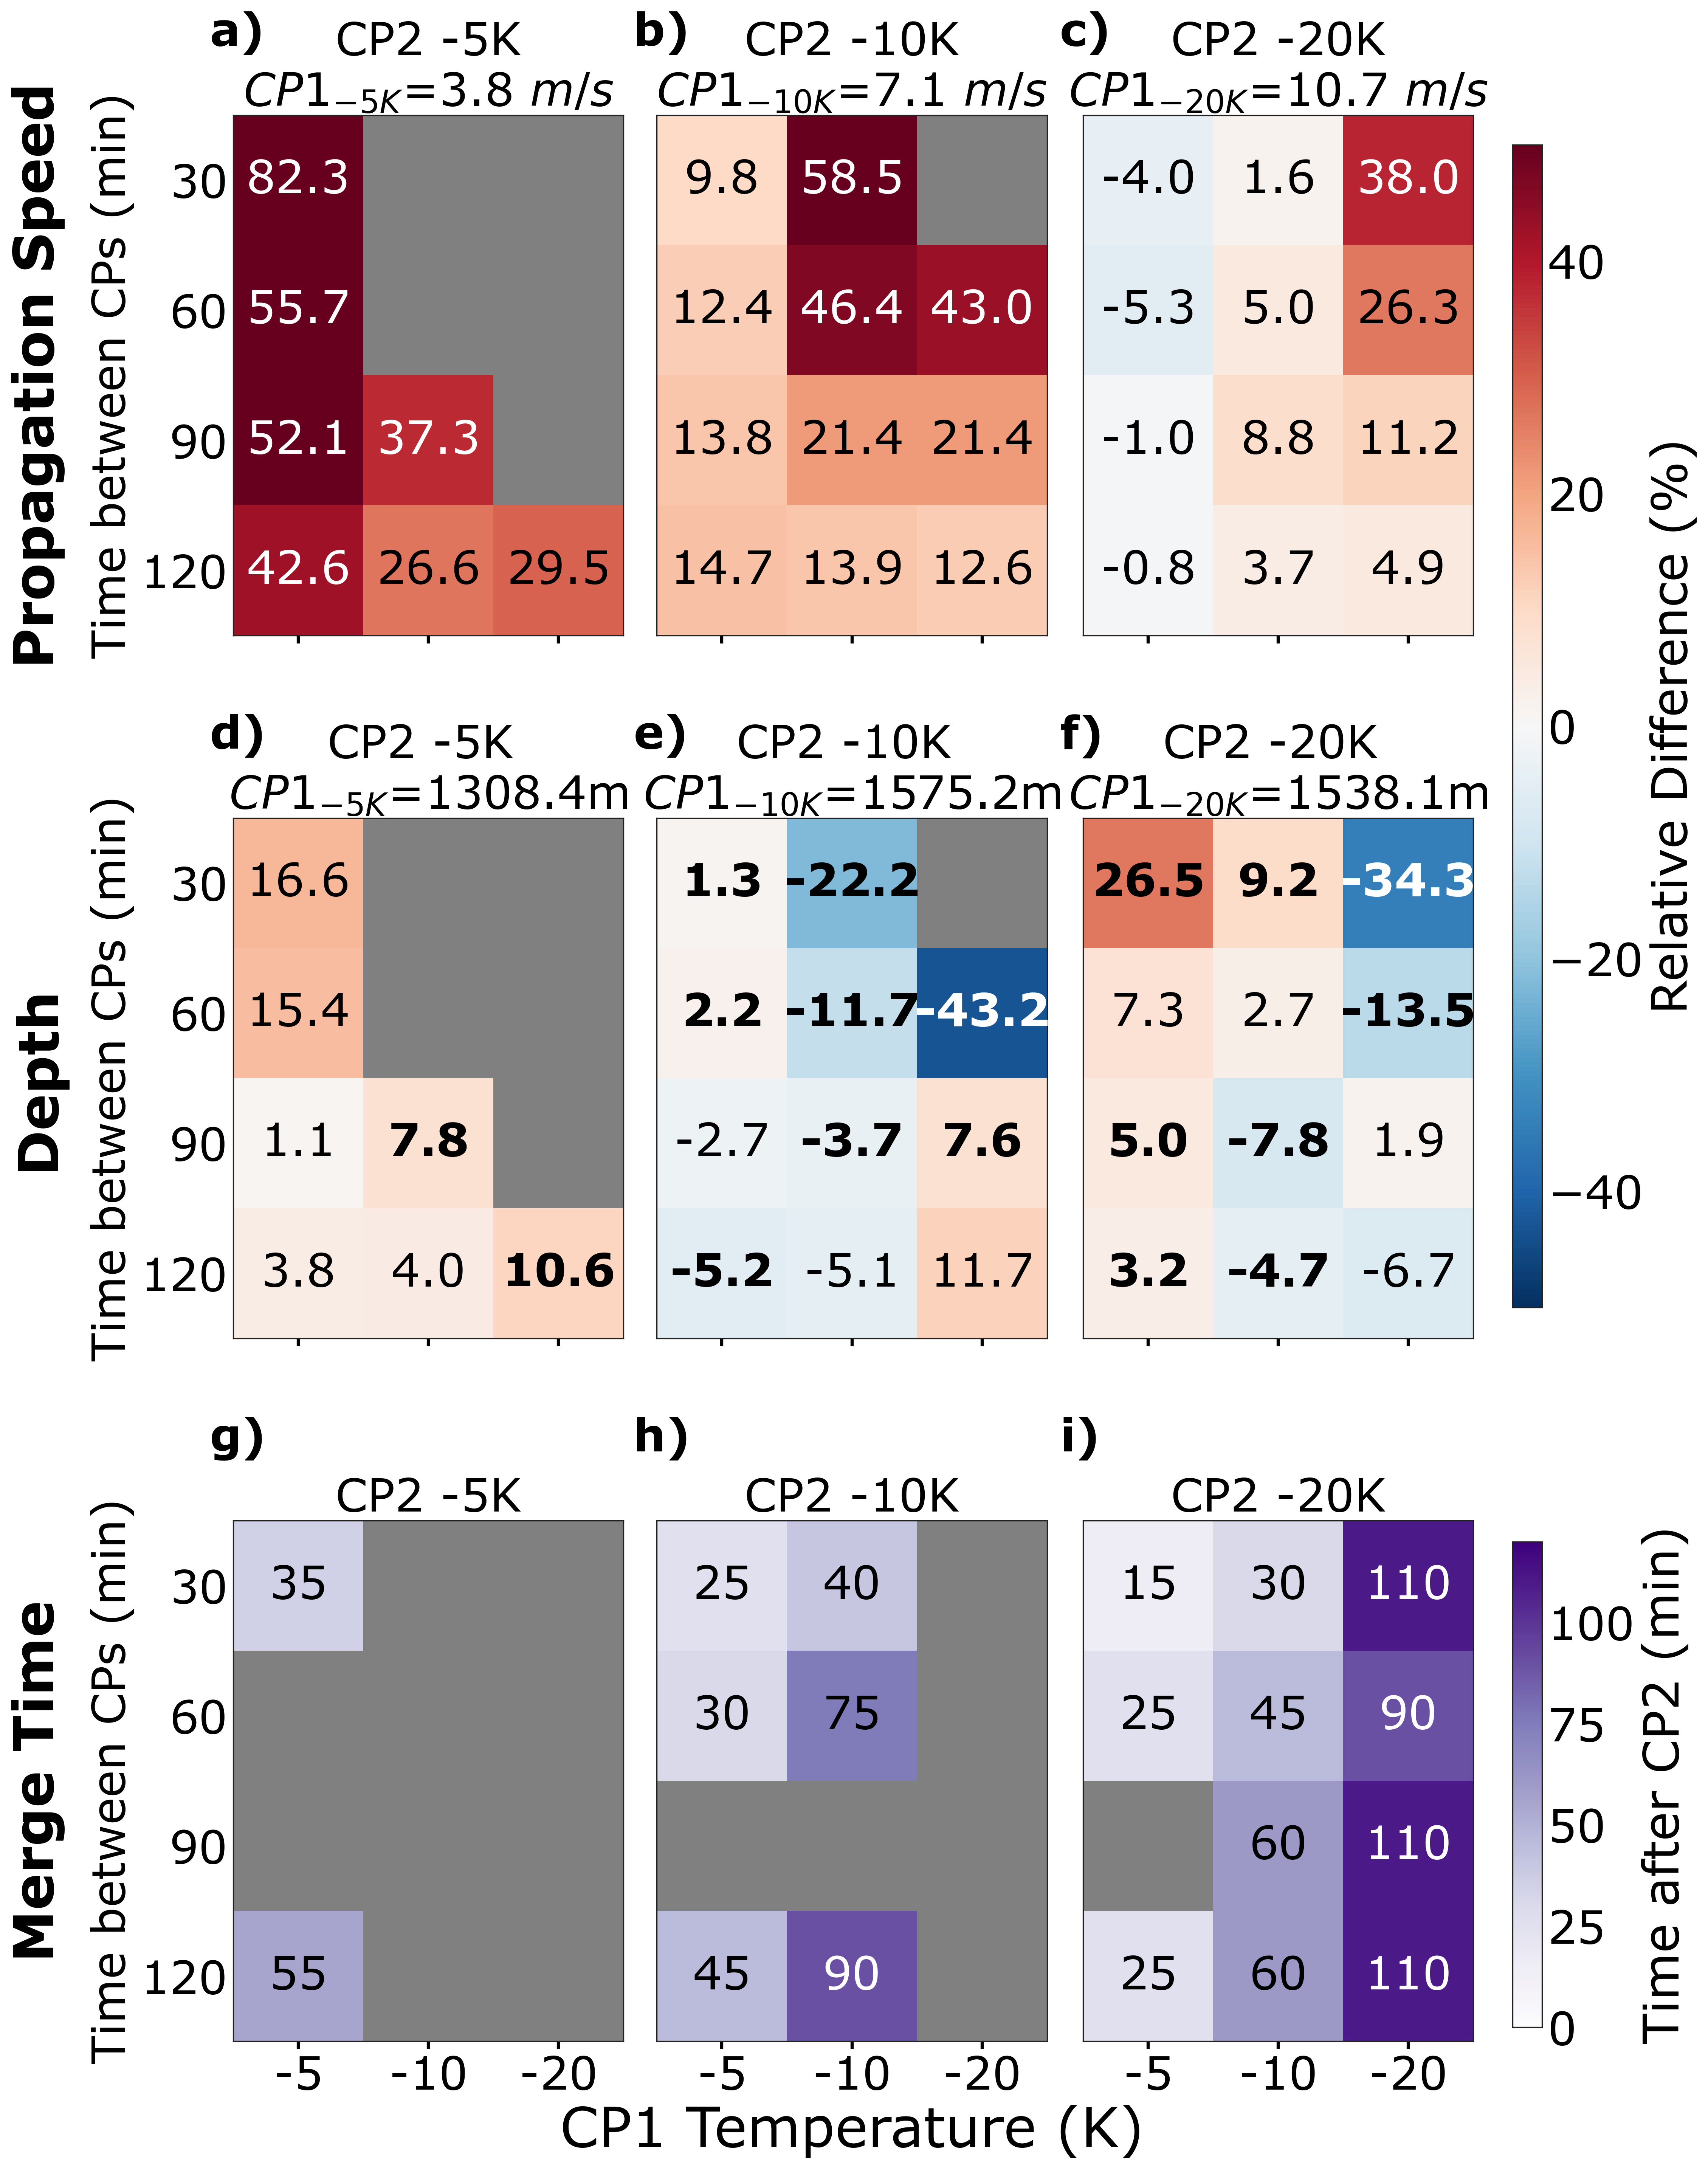

In [22]:
time_avg_list = np.arange(10,11) #averaging over 10 indicies, which is 50 minutes for this simulation
time_start_list = np.arange(0,1) #start averaging at the first available speed timestep
mode_list = ["mean"]
fig, axes= plt.subplots(3,3,figsize = (13,19), constrained_layout = True)
fig.canvas.draw()
for time_avg in time_avg_list:
    for time_start in time_start_list:
        for mode2 in mode_list:
            filePaths = sorted(glob.glob(f"./cpfile_edges_v7/*.h5"))
            speed_dataframe, test_array = func4(filePaths, time_avg,time_start, mode2)
            c=plot_cp2speeds_diffs(test_array,time_avg,time_start,axes,savePath = savePath, mode = "NOWIND", mode2 = mode2)
            c =plot_cp2depths_diffs(depth_array,mask_5k_u0, mask_10k_u0, mask_20k_u0,0.8,q,axes, mode = "NOWIND")  ##for Fig. 3 g-i

            pos1 = axes[0, -1].get_position()
            pos2 = axes[1, -1].get_position()

            # Compute combined vertical span
            cbar_left   = pos1.x1 + 0.05          # a bit to the right of the plots
            cbar_bottom = pos2.y0                  # bottom of 2nd row plot
            cbar_width  = 0.02                     # thickness of colorbar
            cbar_height = pos1.y1 - pos2.y0 -0.02        # total height spanning 2 rows

            # Add the new colorbar axes
            cbar_ax = fig.add_axes([cbar_left, cbar_bottom, cbar_width, cbar_height])
            fig.colorbar(c, cax = cbar_ax, orientation = "vertical").set_label( label = f"Relative Difference (%)",size = 31)

            c = plot_merge_ts(merge_t_array, savePath = savePath, mode = "NOWIND")

            row3_positions = [ax.get_position() for ax in axes[2, :]]
            top_of_row3 = max(p.y1 for p in row3_positions)
            bottom_of_row3 = min(p.y0 for p in row3_positions)
            right_of_row3 = row3_positions[-1].x1

            cbar2_left   = right_of_row3 + 0.05
            cbar2_bottom = bottom_of_row3
            cbar2_width  = 0.02
            cbar2_height = top_of_row3 - bottom_of_row3

            cbar2_ax = fig.add_axes([cbar2_left, cbar2_bottom, cbar2_width, cbar2_height])
            fig.colorbar(c, cax = cbar2_ax, orientation = "vertical").set_label( label = f"Time after CP2 (min)",size = 31)

            plt.savefig(f"{savePath}figure_3_r2.eps", format = 'eps')
            plt.show()
            plt.close()